In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=3
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib
import os
import numpy as np
from openTSNE import TSNE
from openTSNE.affinity import Affinities
import scipy.sparse
from scipy.special import rel_entr
from vis_utils.loaders import load_pendigits
from vis_utils.utils import   KL_divergence, kNN_graph,  save_dict, load_dict,  joint_support, KL_divergence_sparse ,pythagorean_defect, sort_sims_by_proximity, acc_kNN
from vis_utils.plot import hists_from_graph_embd
from vis_utils.tsne_wrapper import TSNEwrapper


env: CUDA_VISIBLE_DEVICES=3


In [2]:
root_path = "/export/ial-nfs/user/sdamrich/nce_data"
fig_path = "/export/ial-nfs/user/sdamrich/nce_data/figures"
# get data
x, y = load_pendigits(root_path)

print(len(x))

5620


# t-SNE

In [3]:
n_epochs = 500
n_early_epochs = 250
perplexity = 30
seed = 0

In [4]:
log_kl = True
log_embds = True
file_name = os.path.join(root_path,
                         "pendigits",
                         f"tsne_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}_log_kl_{log_kl}_log_embds_{log_embds}.pkl")

In [5]:
try:
    tsne_data = load_dict(file_name)
except FileNotFoundError:
    tsne = TSNEwrapper(perplexity=perplexity,
                       metric="euclidean",
                       n_jobs=-1, # n_jobs=-10 does not work well, the cell does not print anything
                       random_state=seed,
                       verbose=True,
                       n_iter = n_epochs,
                       early_exaggeration_iter = n_early_epochs,
                       callbacks_every_iters=1,
                       log_kl=log_kl,
                       log_embds=log_embds)
    embd = tsne.fit_transform(x)
    save_dict(tsne.aux_data, file_name)
    tsne_data = tsne.aux_data

In [16]:
cmap = matplotlib.cm.get_cmap("tab10")

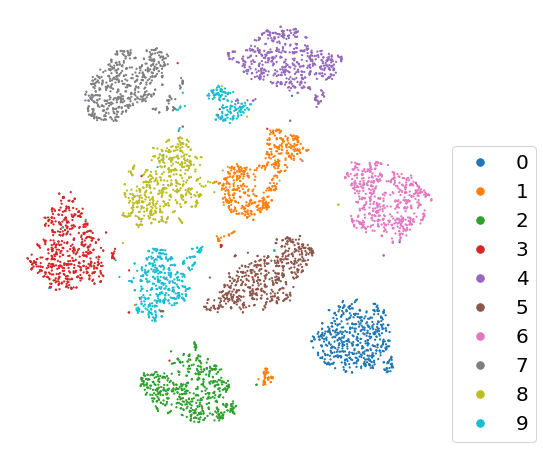

In [27]:
epoch = -1

plt.figure(figsize=(8,8))
plt.scatter(*tsne_data["embds"][epoch].T, c=y, s=20, marker=".", cmap="tab10", edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")

# dummy dots for legend
dots = []
for i in range(len(np.unique(y))):
    dot = mlines.Line2D([], [], color=cmap(i), marker='.', linestyle="none", markersize=15, label=np.unique(y)[i])
    dots.append(dot)

plt.legend(handles=dots, prop={'size': 20}, loc=(1,0))

plt.savefig(os.path.join(fig_path,
                         f"tsne_pen_digits_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

0.009436886252899512


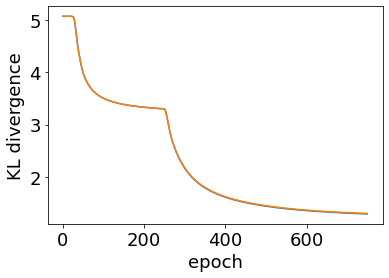

In [31]:
plt.figure()
plt.rcParams['font.size'] = 18
plt.plot(tsne_data["errors"])
plt.plot(tsne_data["kl_div"])
print(np.abs(tsne_data["errors"]-tsne_data["kl_div"]).max())
plt.ylabel("KL divergence")
plt.xlabel("epoch")

plt.savefig(os.path.join(fig_path,
                         f"tsne_pen_digits_KL_div_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)



In [76]:
_, hist_high_pos, _, _, _, hist_low_pos, bins_pos = hists_from_graph_embd(tsne_data["graph"],
                                                                                     tsne_data["embds"][-1],
                                                                                     a=1.0,
                                                                                     b=1.0,
                                                                                     hist_range=(0,1.e-5),
                                                                                     sim_func="cauchy",
                                                                                     norm_embd=True)

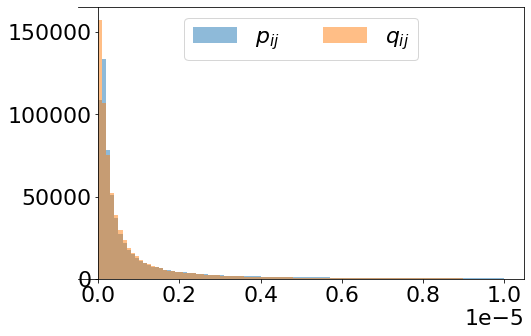

In [99]:
# plot histogram of positive high-dimensional edges
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(8, 5))
plt.hist(bins_pos[:-1], bins_pos, weights=hist_high_pos, alpha=0.5, label=r"$p_{ij}$")
plt.hist(bins_pos[:-1], bins_pos, weights=hist_low_pos, alpha=0.5, label=r"$q_{ij}$")

plt.legend(loc="upper center", ncol=3)
#plt.yscale("symlog", linthresh=1)
plt.gca().spines['left'].set_position("zero")
plt.gca().spines['bottom'].set_position("zero")
plt.savefig(os.path.join(fig_path, f"tsne_pendigits_hist_sims_pos_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)


In [96]:
hist_high, _, _, _, hist_low, _, bins = hists_from_graph_embd(tsne_data["graph"],
                                                              tsne_data["embds"][-1],
                                                              a=1.0,
                                                              b=1.0,
                                                              hist_range=(0,2.e-5),
                                                              sim_func="cauchy",
                                                              norm_embd=True)

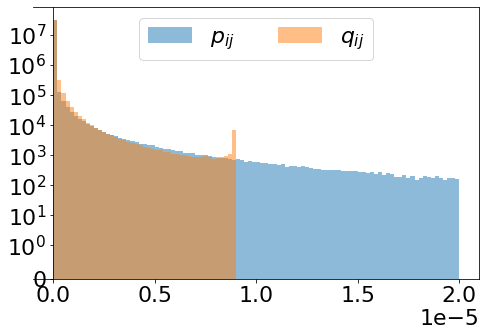

In [98]:

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(8, 5))
_, _, _ = plt.hist(bins[:-1], bins, weights=hist_high, alpha=0.5, label=r"$p_{ij}$")
_, _, _ = plt.hist(bins[:-1], bins, weights=hist_low, alpha=0.5, label=r"$q_{ij}$")
#plt.yscale("log")


plt.legend(loc="upper center", ncol=3)
plt.yscale("symlog", linthresh=1)
plt.gca().spines['left'].set_position("zero")
plt.gca().spines['bottom'].set_position("zero")
plt.savefig(os.path.join(fig_path, f"tsne_pendigits_hist_sims_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

### Comparing symmetrized TSNE and kNN similarities

In [6]:
sorted_sims = sort_sims_by_proximity(tsne_data["graph"], k=4*perplexity, x=x)

[pyKeOps] Initializing build folder for dtype=float64 and lang=torch in /export/home/sdamrich/.cache/pykeops-1.5-cpython-38-gpu3 ... done.
[pyKeOps] Compiling libKeOpstorch3f236f52de in /export/home/sdamrich/.cache/pykeops-1.5-cpython-38-gpu3:
       formula: ArgKMin_Reduction(Sum(Square((Var(0,64,0) - Var(1,64,1)))),121,1)
       aliases: Var(0,64,0); Var(1,64,1); 
       dtype  : float64
... 
[pyKeOps] Compiling pybind11 template libKeOps_template_3199def6f5 in /export/home/sdamrich/.cache/pykeops-1.5-cpython-38-gpu3 ... done.
Done.
[pyKeOps] Compiling libKeOpstorch04a3a6eabc in /export/home/sdamrich/.cache/pykeops-1.5-cpython-38-gpu3:
       formula: KMin_Reduction(Sum(Square((Var(0,64,0) - Var(1,64,1)))),121,1)
       aliases: Var(0,64,0); Var(1,64,1); 
       dtype  : float64
... 
Done.


In [7]:
assert perplexity % 2 == 0
knn_graph = kNN_graph(x.astype("float"),
                      int(perplexity / 2),
                      metric="euclidean").cpu().numpy().flatten()
knn_graph = scipy.sparse.coo_matrix((np.ones(len(x)*int(perplexity/2)),
                                     (np.repeat(np.arange(x.shape[0]), int(perplexity/2)),
                                      knn_graph)),
                                    shape=(len(x), len(x)))
sknn_graph = knn_graph.maximum(knn_graph.transpose()).tocoo()

[pyKeOps] Compiling libKeOpstorch9676ad0685 in /export/home/sdamrich/.cache/pykeops-1.5-cpython-38-gpu3:
       formula: ArgKMin_Reduction(Sum(Square((Var(0,64,0) - Var(1,64,1)))),16,1)
       aliases: Var(0,64,0); Var(1,64,1); 
       dtype  : float64
... 
Done.


In [8]:
sorted_bin_sims = sort_sims_by_proximity(sknn_graph, k=4*perplexity, x=x)
sorted_bin_sims /= sknn_graph.sum()

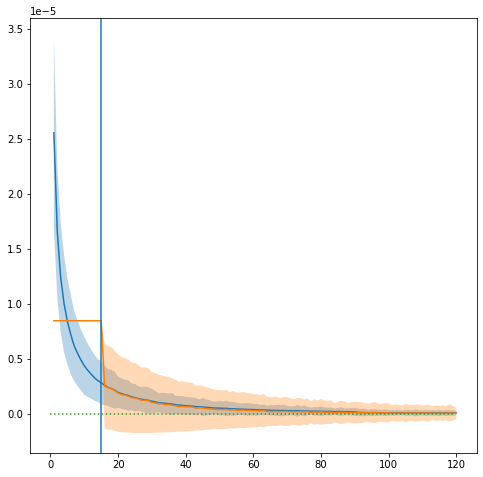

In [9]:
plt.figure(figsize=(8,8))
sorted_sims_mean = sorted_sims.mean(0)
sorted_sims_std = sorted_sims.std(0)
plt.plot(np.arange(len(sorted_sims_mean))+1, sorted_sims_mean)
plt.fill_between(np.arange(len(sorted_sims_mean))+1,
                 sorted_sims_mean-sorted_sims_std,
                 sorted_sims_mean+sorted_sims_std,
                 alpha=0.3)


sorted_bin_sims_mean = sorted_bin_sims.mean(0)
sorted_bin_sims_std = sorted_bin_sims.std(0)
plt.plot(np.arange(len(sorted_bin_sims_mean))+1, sorted_bin_sims_mean)
plt.fill_between(np.arange(len(sorted_bin_sims_mean))+1,
                 sorted_bin_sims_mean-sorted_bin_sims_std,
                 sorted_bin_sims_mean+sorted_bin_sims_std,
                 alpha=0.3)
plt.plot(np.zeros(len(sorted_bin_sims_mean)), linestyle="dotted")
plt.axvline(15)

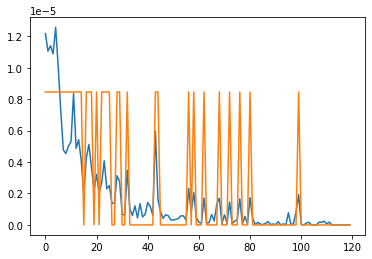

In [89]:
i = 6
plt.plot(sorted_sims[i])
plt.plot(sorted_bin_sims[i])

### non-symmetrized similarities

In [11]:
tsne = TSNEwrapper(perplexity=perplexity,
                   metric="euclidean",
                   n_jobs=-1, # n_jobs=-10 does not work well, the cell does not print anything
                   random_state=seed,
                   verbose=True,
                   n_iter=10,
                   early_exaggeration_iter = 5,
                   callbacks_every_iters=1,
                   log_kl=False,
                   log_embds=False)
embd = tsne.fit_transform(x)


--------------------------------------------------------------------------------
TSNE(callbacks=[<vis_utils.tsne_wrapper.Logger object at 0x7f4fe59d27f0>],
     callbacks_every_iters=1, early_exaggeration_iter=5, n_iter=10, n_jobs=-1,
     random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 1.69 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.41 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=12.00, lr=468.33 for 5 iterations...
   --> Time elapsed: 0.09 seconds
===> Running optimization with exaggeration=1.00, lr=468.33 for 10 iterations...
   --> Time elapsed: 0.21 seconds


In [12]:
from openTSNE.affinity import joint_probabilities_nn

In [13]:
probs = joint_probabilities_nn(
                embd.affinities._PerplexityBasedNN__neighbors,
                embd.affinities._PerplexityBasedNN__distances,
                [30.],
                symmetrize=False,
                normalization="point-wise",
                n_jobs=1,
            )

In [14]:
sorted_asym_sims = sort_sims_by_proximity(probs, k=4*perplexity, x=x)

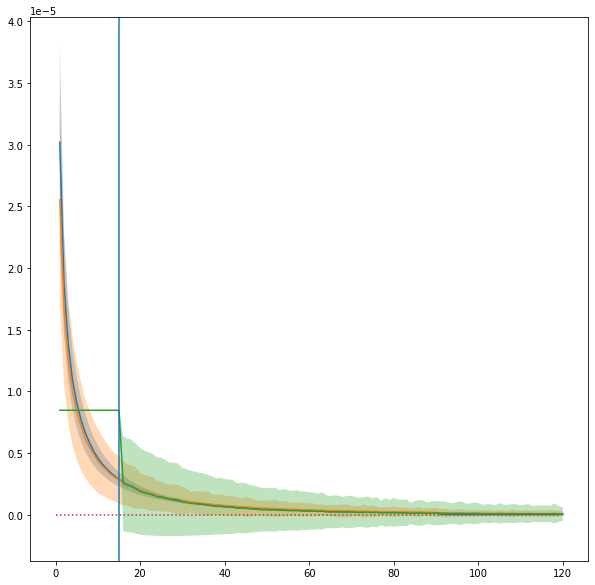

In [15]:
plt.figure(figsize=(10,10))
sorted_asym_sims_pair = sorted_asym_sims / len(x)
sorted_asym_sims_mean = sorted_asym_sims_pair.mean(0)
sorted_asym_sims_std = sorted_asym_sims_pair.std(0)
plt.plot(np.arange(len(sorted_asym_sims_mean))+1, sorted_asym_sims_mean)
plt.fill_between(np.arange(len(sorted_asym_sims_mean))+1,
                 sorted_asym_sims_mean-sorted_asym_sims_std,
                 sorted_asym_sims_mean+sorted_asym_sims_std,
                 alpha=0.3)



sorted_sims_mean = sorted_sims.mean(0)
sorted_sims_std = sorted_sims.std(0)
plt.plot(np.arange(len(sorted_sims_mean))+1, sorted_sims_mean)
plt.fill_between(np.arange(len(sorted_sims_mean))+1,
                 sorted_sims_mean-sorted_sims_std,
                 sorted_sims_mean+sorted_sims_std,
                 alpha=0.3)


sorted_bin_sims_mean = sorted_bin_sims.mean(0)
sorted_bin_sims_std = sorted_bin_sims.std(0)
plt.plot(np.arange(len(sorted_bin_sims_mean))+1, sorted_bin_sims_mean)
plt.fill_between(np.arange(len(sorted_bin_sims_mean))+1,
                 sorted_bin_sims_mean-sorted_bin_sims_std,
                 sorted_bin_sims_mean+sorted_bin_sims_std,
                 alpha=0.3)
plt.plot(np.zeros(len(sorted_bin_sims_mean)), linestyle="dotted")
plt.axvline(15)

### Comparing to UMAP as well

In [14]:
import pickle
filename = os.path.join(root_path, "pendigits", f"umap_n_epochs_750_0.pkl")

with open(filename, "rb") as file:
    umapper = pickle.load(file)
    embd_after = umapper.embedding_

Sun Jan 23 13:40:07 2022 Building and compiling search function


In [18]:
sorted_umap_sims = sort_sims_by_proximity(umapper.graph_, k=4*perplexity, x=x)

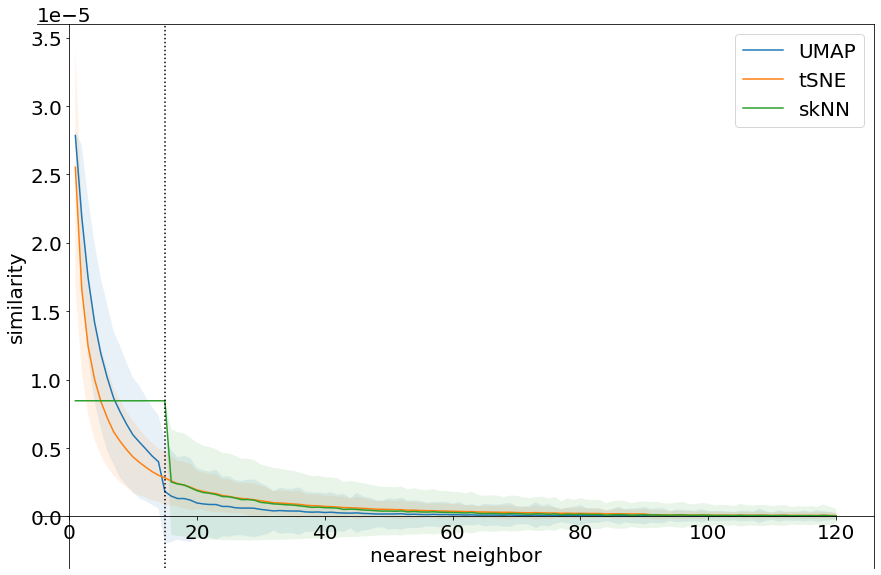

In [20]:
plt.figure(figsize=(15,10))
plt.rcParams['font.size'] = 20

sorted_umap_sims_norm = sorted_umap_sims / umapper.graph_.sum()
sorted_umap_sims_mean = sorted_umap_sims_norm.mean(0)
sorted_umap_sims_std = sorted_umap_sims_norm.std(0)
plt.plot(np.arange(len(sorted_umap_sims_mean))+1, sorted_umap_sims_mean, label="UMAP")
plt.fill_between(np.arange(len(sorted_umap_sims_mean))+1,
                 sorted_umap_sims_mean-sorted_umap_sims_std,
                 sorted_umap_sims_mean+sorted_umap_sims_std,
                 alpha=0.1)



sorted_sims_mean = sorted_sims.mean(0)
sorted_sims_std = sorted_sims.std(0)
plt.plot(np.arange(len(sorted_sims_mean))+1, sorted_sims_mean, label="tSNE")
plt.fill_between(np.arange(len(sorted_sims_mean))+1,
                 sorted_sims_mean-sorted_sims_std,
                 sorted_sims_mean+sorted_sims_std,
                 alpha=0.1)


sorted_bin_sims_mean = sorted_bin_sims.mean(0)
sorted_bin_sims_std = sorted_bin_sims.std(0)
plt.plot(np.arange(len(sorted_bin_sims_mean))+1, sorted_bin_sims_mean, label="skNN")
plt.fill_between(np.arange(len(sorted_bin_sims_mean))+1,
                 sorted_bin_sims_mean-sorted_bin_sims_std,
                 sorted_bin_sims_mean+sorted_bin_sims_std,
                 alpha=0.1)
plt.axvline(15, c="k", linestyle="dotted")
plt.legend()

# set the y-spine
plt.gca().spines['left'].set_position('zero')
plt.gca().spines['bottom'].set_position('zero')

plt.xlabel("nearest neighbor")
plt.ylabel("similarity")

plt.savefig(os.path.join(fig_path,
                         f"similarities_by_neighbors_tnse_umap_skNN_perplexity_{perplexity}_k_{int(perplexity/2)}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

## KL divergences

### tSNE

In [367]:
kl_sknn_tsne = KL_divergence_sparse(sknn_graph, tsne_data["graph"])

In [324]:
kl_sknn_embd = KL_divergence(high_sim=sknn_graph,
                             embedding=tsne_data["embds"][-1],
                             a=1.0,
                             b=1.0,
                             norm_over_pos=False,
                             eps=np.finfo("float").eps)

In [325]:
kl_tsne_embd = KL_divergence(high_sim=tsne_data["graph"],
                             embedding=tsne_data["embds"][-1],
                             a=1.0,
                             b=1.0,
                             norm_over_pos=False,
                             eps=np.finfo("float").eps)

In [368]:
print(kl_sknn_tsne + kl_tsne_embd)
print(kl_sknn_embd)

1.9124522176731897
2.057340242889838


In [337]:
defect = pythagorean_defect(sknn_graph, tsne_data["graph"], embedding=tsne_data["embds"][-1])

0.0023977704066253194
9316.963598277554


In [333]:
defect

-0.14488802526564853

In [369]:
print(kl_sknn_tsne)
print(kl_tsne_embd)
print(kl_sknn_embd)
print(defect)

print(kl_sknn_tsne + kl_tsne_embd - defect)
print(kl_sknn_embd - kl_sknn_tsne - kl_tsne_embd + defect)

0.616830327136153
1.2956218905370367
2.057340242889838
-0.14488802526564853
2.0573402429388383
-4.900030381449483e-11


### UMAP

# TSNE with binary affinities

In [6]:
log_kl = True
log_embds = True

file_name = os.path.join(root_path,
                         "pendigits",
                         f"tsne_bin_k_{int(perplexity / 2)}_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}_log_kl_{log_kl}_log_embds_{log_embds}.pkl")

In [8]:
assert perplexity % 2 == 0
knn_graph = kNN_graph(x.astype("float"),
                      int(perplexity / 2),
                      metric="euclidean").cpu().numpy().flatten()
knn_graph = scipy.sparse.coo_matrix((np.ones(len(x)*int(perplexity/2)),
                                     (np.repeat(np.arange(x.shape[0]), int(perplexity/2)),
                                      knn_graph)),
                                    shape=(len(x), len(x)))
sknn_graph = knn_graph.maximum(knn_graph.transpose()).tocoo()
affinities = Affinities()
affinities.P = (sknn_graph / sknn_graph.sum()).tocsr()

In [9]:

try:
    tsne_data_bin = load_dict(file_name)
except FileNotFoundError:
    tsne_bin = TSNEwrapper(perplexity=perplexity,
                       metric="euclidean",
                       n_jobs=-1, # n_jobs=-10 does not work well, the cell does not print anything
                       random_state=seed,
                       verbose=True,
                       n_iter = n_epochs,
                       early_exaggeration_iter = n_early_epochs,
                       callbacks_every_iters=1,
                       log_kl=log_kl,
                       log_embds=log_embds)
    embd_bin = tsne_bin.fit_transform(x, affinities=affinities)
    save_dict(tsne_bin.aux_data, file_name)
    tsne_data_bin = tsne_bin.aux_data

--------------------------------------------------------------------------------
TSNE(callbacks=[<vis_utils.tsne_wrapper.Logger object at 0x7f27e958d220>],
     callbacks_every_iters=1, n_jobs=-1, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.07 seconds
===> Running optimization with exaggeration=12.00, lr=468.33 for 250 iterations...
Iteration   50, KL divergence 4.4903, 50 iterations in 3.9349 sec
Iteration  100, KL divergence 4.0001, 50 iterations in 3.6428 sec
Iteration  150, KL divergence 3.8806, 50 iterations in 5.2652 sec
Iteration  200, KL divergence 3.8273, 50 iterations in 3.3128 sec
Iteration  250, KL divergence 3.7969, 50 iterations in 3.3223 sec
   --> Time elapsed: 19.48 seconds
===> Running optimization with exaggeration=1.00, lr=468.33 for 500 iterations...
Iteration   50, KL divergence 2.7034, 50 iterations in 3.4578 sec
Iteration  100, K

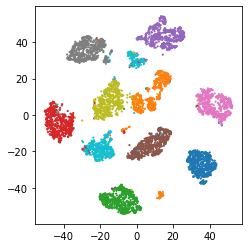

In [10]:
epoch = -1
plt.scatter(*tsne_data_bin["embds"][epoch].T, c=y, s=5, marker=".", cmap="tab10")
plt.gca().set_aspect("equal")

0.009004858673021587


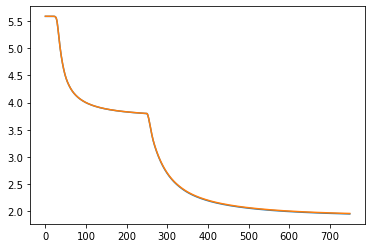

In [11]:

plt.plot(tsne_data_bin["errors"])
plt.plot(tsne_data_bin["kl_div"])
print(np.abs(tsne_data_bin["errors"] - tsne_data_bin["kl_div"]).max())

In [14]:
KL_divergence(sknn_graph, tsne_data["embds"][-1])

2.057333417553533

In [18]:
KL_divergence(sknn_graph, tsne_data_bin["embds"][-1])

1.9582388122052308

In [15]:
KL_divergence(tsne_data["graph"], tsne_data_bin["embds"][-1])

1.4634782992127437

In [16]:
pythagorean_defect(sknn_graph, tsne_data["graph"], embedding = tsne_data_bin["embds"][-1])

0.12207014688668133

In [21]:
KL_divergence_sparse(sknn_graph, tsne_data["graph"])

0.616830327136153

## kNN acc AUC

In [12]:
ks = [1,2,3,4,5,6,7,8,9, 10,11,12,13,14, 15, 20, 25, 30, 40, 50, 60, 70, 80, 100]

knn_by_graph_tsne = []
for embd in [tsne_data["embds"][-1], tsne_data_bin["embds"][-1]]:
    knn_accs = []
    for k in ks:
        knn_accs.append(acc_kNN(x.astype("float"), embd, k=k))
    knn_by_graph_tsne.append(knn_accs)
knn_by_graph_tsne = np.array(knn_by_graph_tsne)


In [23]:
import umap
lr = 1.0

n_epochs_umap = n_epochs + n_early_epochs

filename = os.path.join(root_path, "pendigits", f"umap_n_epochs_{n_epochs_umap}_lr_{lr}_seed_{seed}.pkl")
try:
    with open(filename, "rb") as file:
        umapper = pickle.load(file)
except FileNotFoundError:
    umapper = umap.UMAP(n_neighbors=int(perplexity/2),
                                n_epochs=n_epochs_umap,
                                log_losses="after",
                                log_embeddings=True,
                                log_norm=True,
                                log_kl=True,
                                random_state=seed,
                                verbose=True,
                                learning_rate=lr)
    _ = umapper.fit_transform(x)
    with open(filename, "wb") as file:
        pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)

Sun Jan 23 13:44:51 2022 Building and compiling search function


In [24]:
n_epochs_umap = n_epochs + n_early_epochs
filename = os.path.join(root_path, "pendigits", f"umap_bin_k_{int(perplexity/2)}_n_epochs_{n_epochs}_seed_{seed}.pkl")
try:
    with open(filename, "rb") as file:
        umapper_bin = pickle.load(file)
except FileNotFoundError:
    umapper_bin = umap.UMAP(n_neighbors=int(perplexity/2),
                                n_epochs=n_epochs_umap,
                                log_losses="after",
                                log_embeddings=True,
                                log_norm=True,
                                log_kl=True,
                                random_state=seed,
                                verbose=True,
                                learning_rate=lr,
                            graph=sknn_graph)
    _ = umapper_bin.fit_transform(x)
    with open(filename, "wb") as file:
        pickle.dump(umapper_bin, file, pickle.HIGHEST_PROTOCOL)

UMAP(dens_frac=0.0, dens_lambda=0.0, log_embeddings=True, log_kl=True,
     log_losses='after', log_norm=True, n_epochs=750, random_state=0,
     verbose=True)
Construct fuzzy simplicial set
Sun Jan 23 13:45:14 2022 Construct embedding


/export/data/sdamrich/anaconda3/envs/nce/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


	completed  0  /  750 epochs
	completed  75  /  750 epochs
	completed  150  /  750 epochs
	completed  225  /  750 epochs
	completed  300  /  750 epochs
	completed  375  /  750 epochs
	completed  450  /  750 epochs
	completed  525  /  750 epochs
	completed  600  /  750 epochs
	completed  675  /  750 epochs
Sun Jan 23 13:50:02 2022 Finished embedding


In [25]:
print(umapper.graph_.data)
print(umapper_bin.graph_.data)

[0.3919703  0.21391965 1.         ... 0.6139663  0.33852267 0.19473624]
[1. 1. 1. ... 1. 1. 1.]


In [26]:

knn_by_graph_umap = []
for embd in [umapper.aux_data["embeddings"][-1], umapper_bin.aux_data["embeddings"][-1]]:
    knn_accs = []
    for k in ks:
        knn_accs.append(acc_kNN(x.astype("float"), embd.astype("float"), k=k))
    knn_by_graph_umap.append(knn_accs)
knn_by_graph_umap = np.array(knn_by_graph_umap)


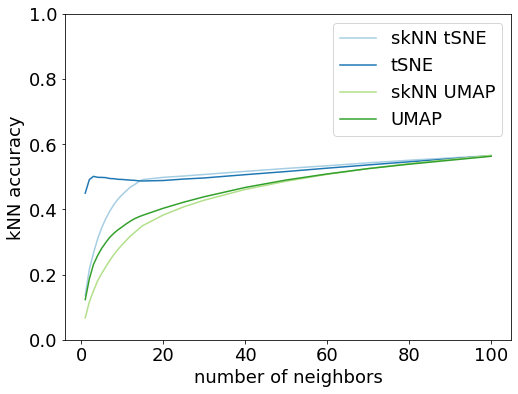

In [47]:
import seaborn as sns
plt.figure(figsize=(8,6))
plt.rcParams['font.size'] = 18

with sns.color_palette("Paired", n_colors=4):
    plt.plot(ks, knn_by_graph_tsne[1], label="skNN tSNE")
    plt.plot(ks, knn_by_graph_tsne[0], label="tSNE")

    plt.plot(ks, knn_by_graph_umap[1], label="skNN UMAP")
    plt.plot(ks, knn_by_graph_umap[0], label="UMAP")
plt.ylim((0, 1))
plt.ylabel("kNN accuracy")
plt.xlabel("number of neighbors")
plt.legend()

plt.savefig(os.path.join(fig_path,
                         f"kNN_AUC_umap_tsne_pen_digits_n_epochs_umap_{n_epochs_umap}_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

In [41]:
end = -1

In [43]:
np.trapz(knn_by_graph_tsne[0][:end], ks[:end]) / ks[end]

0.40300078874269263

In [44]:
np.trapz(knn_by_graph_tsne[1][:end], ks[:end]) / ks[end]

0.3934962922333697

In [45]:
np.trapz(knn_by_graph_umap[0][:end], ks[:end]) / ks[end]

0.3525829349426769

In [46]:
np.trapz(knn_by_graph_umap[1][:end], ks[:end]) / ks[end]


0.33974367314674253

## no early exaggeration

In [66]:
n_epochs = 10000
n_early_epochs = 0
perplexity = 30
seed = 0
log_kl = True
log_embds = True
file_name = os.path.join(root_path,
                         "pendigits",
                         f"tsne_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}_log_kl_{log_kl}_log_embds_{log_embds}.pkl")

In [67]:

try:
    tsne_data = load_dict(file_name)
except FileNotFoundError:
    tsne = TSNEwrapper(perplexity=perplexity,
                       metric="euclidean",
                       n_jobs=-1,
                       # n_jobs=-10 does not work well, the cell does not print anything
                       random_state=seed,
                       verbose=True,
                       n_iter=n_epochs,
                       early_exaggeration_iter=n_early_epochs,
                       callbacks_every_iters=1,
                       log_kl=log_kl,
                       log_embds=log_embds)
    embd = tsne.fit_transform(x)
    save_dict(tsne.aux_data, file_name)
    tsne_data = tsne.aux_data


--------------------------------------------------------------------------------
TSNE(callbacks=[<vis_utils.tsne_wrapper.Logger object at 0x7f91cc066460>],
     callbacks_every_iters=1, early_exaggeration_iter=0, n_iter=10000,
     n_jobs=-1, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 1.82 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.58 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.11 seconds
===> Running optimization with exaggeration=12.00, lr=468.33 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.00, lr=468.33 for 10000 iterations...
Iteration   50, KL divergence 2.3765, 50 iterations in 12.3973 sec
Iteration  100, KL divergence 1.8615, 50 iterations in 12.5164 sec
Iteration  150, KL divergence 1.6573,

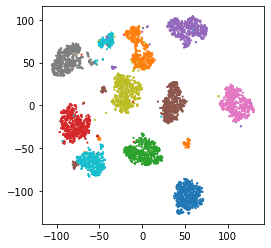

In [68]:
epoch = -1
plt.scatter(*tsne_data["embds"][epoch].T, c=y, s=5, marker=".", cmap="tab10")
plt.gca().set_aspect("equal")


1.1947398002526572


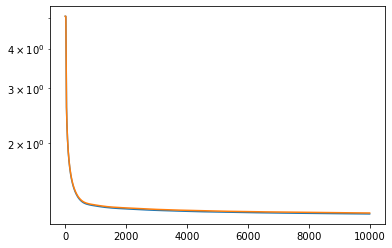

In [70]:

plt.plot(tsne_data["errors"])
plt.plot(tsne_data["kl_div"])
#plt.yscale("log")
print(tsne_data["kl_div"][-1])